In [1]:
from MMI_solver import MMI, create_ridge,create_ridge2,create_ridge_butterfly_B,create_ridge_butterfly_ACD,create_taper,create_3D_MMI_simulation_butterfly_D
import gplugins.tidy3d.materials as mat
import numpy as np
import tidy3d as td
import matplotlib.pyplot as plt
import tidy3d.web as web
from scipy.optimize import minimize
import autograd as ag
import autograd.numpy as anp

ratio_bar,ratio_cross = 0.32,0.68



/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/skfem/assembly/form/linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/skfem/assembly/form/linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


[-7.         -6.98631476 -6.97262952 ...  6.97262952  6.98631476
  7.        ]


/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/skfem/assembly/form/linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


  0%|          | 0/1000 [00:00<?, ?it/s]

ratio_out [0.52183163+0.j 0.47816837+0.j]
excess_loss (4.560204879798005+0j)
Lpi_TE 62.224741625920664


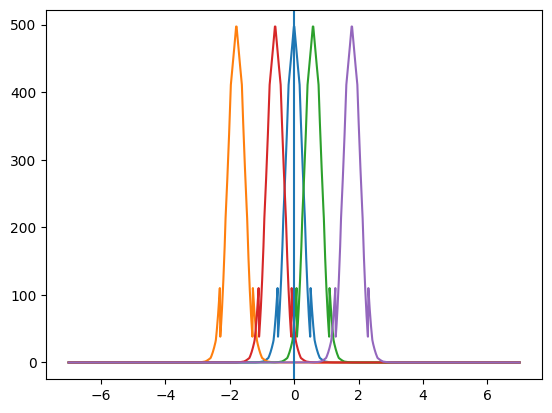

In [2]:
Len_MMI = 59.92/2 #longitud del MMI
wvl = 1.55 #longitud de onda
mat_core = mat.sin(1.55) #material del core
mat_clad = mat.sio2(1.55) #material del clad
input_number = 2 #número de waveguides de entrada
output_number = 2 #número de waveguides de salida
input_positions = [-3/10,1/10] #posiciones de las waveguides de entrada
output_positions = [-1/10,3/10] #la maxima posicion es [-1/2,1/2]
wg_array_width=1.00 #anchura de la waveguide de entrada/salida
wg_array_thickness=0.8 #altura de la waveguide de entrada/salida, es igual que la del MMI
MMI_width=6.0 #anchura del MMI
MMI_num_modes=20#número de modos del MMI a calcular
slices=1024
gap1 = (input_positions[1]-input_positions[0]) * MMI_width - wg_array_width #distancia entre waveguides de entrada/salida

gap = (input_positions[1]-input_positions[0]) * MMI_width #distancia entre waveguides de entrada/salida
ratio_out ,excess_loss, L_v, intensidad_L, Lpi_TE, Lpi_TM, neff_TE = MMI(
    Len_MMI, #longitud del MMI
    wvl , #longitud de onda
    mat_core, #material del core
    mat_clad, #material del clad
    input_number, #número de waveguides de entrada
    output_number, #número de waveguides de salida
    input_positions, #posiciones de las waveguides de entrada
    output_positions, #la maxima posicion es [-1/2,1/2]
    wg_array_width, #anchura de la waveguide de entrada/salida
    wg_array_thickness, #altura de la waveguide de entrada/salida, es igual que la del MMI
    MMI_width, #anchura del MMI
    MMI_num_modes, #número de modos del MMI a calcular
    slices,
    gap1  #distancia entre waveguides de entrada/salida
)
print('ratio_out', ratio_out)
print('excess_loss', excess_loss)
print('Lpi_TE', Lpi_TE)

In [3]:
punto_exp = 47 #punto de la longitud del MMI a calcular, 0 es el mínimo y 99 es el máximo
#ahora empezaremos con la parte de tidy3d
Len_MMI_ = np.linspace(Lpi_TE/100,Lpi_TE,100) #longitud del MMI
Len_MMI = Len_MMI_[punto_exp] #longitud del MMI

#sin = mat_core
#sio2 = mat_clad
wvlenth = np.linspace(1.5,1.6,101)
freqs = td.C_0 / wvlenth
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))
freq0 = td.C_0 / 1.55
wvg_length = 1000
taper_length = 5.0
len_corner = taper_length
#en primer lugar, definimos los materiales

#sin = td.material_library['SiN']['Horiba'] #cristaline silicon
#sio2 = td.material_library['SiO2']['Horiba']

n_sin = 1.99
n_sio2 = 1.44

sin = td.Medium(permittivity=n_sin**2)
sio2 = td.Medium(permittivity=n_sio2**2)

width_dif = 0.23

balance_weight,loss_weight = 15, 0.5
balance_weight2,loss_weight2 = 150, 5

opt_len = 1.4

In [4]:
for i in range(2):
    input_positions[i] = input_positions[i] * MMI_width
    output_positions[i] = output_positions[i] * MMI_width
print('input_positions', input_positions)

#Len_c = 4/3 * neff_TE[0]*(MMI_width * (MMI_width-width_dif))/1.55
#Len_MMI = Len_c /2 -0.7
neff_TE0 = neff_TE[0]

input_positions [-1.7999999999999998, 0.6000000000000001]


In [5]:
def objective_width(opt_len_array):
    width_dif = opt_len_array[0]  # Convert to list for compatibility with the MMI function
    par, L =create_3D_MMI_simulation_butterfly_D(opt_len, width_dif,ratio_bar,ratio_cross,neff_TE0,MMI_width, wg_array_thickness, wg_array_width,wvg_length, taper_length, freq0, fwidth, sin, sio2,freqs,len_corner,balance_weight,loss_weight)

    return par

bounds = [(0,MMI_width/2)]  # Definir los límites de la longitud del MMI
width_dif = width_dif
res = minimize(objective_width, [width_dif], bounds=bounds, method='nelder-mead')

width_dif2 = res.x[0]
print(f"Diferencia minima: {res.fun:.4f}")

print(width_dif)

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


18:04:58 CEST WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=591521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=198747;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\taskId]8;;\]8;id=591521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\=]8;;\]8;id=29252;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\fdve]8;;\]8;id=591521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\-c83a8a81-c9]8;;\
              ]8;id=591521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\1f-4dae-99fb-f8101883ef79']8;;\.

              Task folder: ]8;id=775027;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:05:01 CEST Maximum FlexCredit cost: 0.111. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:05:02 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:05:09 CEST status = preprocess

18:05:20 CEST starting up solver

18:05:21 CEST running solver

Output()

18:05:37 CEST early shutoff detected at 28%, exiting.

18:05:38 CEST status = postprocess

Output()

18:05:40 CEST status = success

18:05:42 CEST View simulation result at                                         
              ]8;id=781180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=963663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\taskId]8;;\]8;id=781180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\=]8;;\]8;id=297522;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\fdve]8;;\]8;id=781180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\-c83a8a81-c9]8;;\
              ]8;id=781180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c83a8a81-c91f-4dae-99fb-f8101883ef79\1f-4dae-99fb-f8101883ef79']8;;\.

Output()

18:05:46 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-c4c7db06-967a-49ae-8a14-180a9694016e' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=63420;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=635069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\taskId]8;;\]8;id=63420;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\=]8;;\]8;id=114371;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\fdve]8;;\]8;id=63420;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\-c4c7db06-96]8;;\
              ]8;id=63420;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\7a-49ae-8a14-180a9694016e']8;;\.

              Task folder: ]8;id=888181;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:05:48 CEST Maximum FlexCredit cost: 0.111. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:05:49 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:05:56 CEST status = preprocess

18:06:07 CEST starting up solver

18:06:08 CEST running solver

Output()

18:06:23 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:06:25 CEST status = success

18:06:27 CEST View simulation result at                                         
              ]8;id=539213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=415142;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\taskId]8;;\]8;id=539213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\=]8;;\]8;id=213930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\fdve]8;;\]8;id=539213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\-c4c7db06-96]8;;\
              ]8;id=539213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4c7db06-967a-49ae-8a14-180a9694016e\7a-49ae-8a14-180a9694016e']8;;\.

Output()

18:06:31 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=241872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=381535;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\taskId]8;;\]8;id=241872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\=]8;;\]8;id=749674;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\fdve]8;;\]8;id=241872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\-bcfb5b4f-67]8;;\
              ]8;id=241872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\f8-40a9-84ca-f01bfb4813ed']8;;\.

              Task folder: ]8;id=920215;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:06:33 CEST Maximum FlexCredit cost: 0.111. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:06:34 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:06:41 CEST status = preprocess

18:06:50 CEST starting up solver

18:06:51 CEST running solver

Output()

18:07:08 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:07:19 CEST status = success

18:07:21 CEST View simulation result at                                         
              ]8;id=31052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=68434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\taskId]8;;\]8;id=31052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\=]8;;\]8;id=118172;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\fdve]8;;\]8;id=31052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\-bcfb5b4f-67]8;;\
              ]8;id=31052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bcfb5b4f-67f8-40a9-84ca-f01bfb4813ed\f8-40a9-84ca-f01bfb4813ed']8;;\.

Output()

18:07:25 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-82d78322-1b66-4e96-aa76-12dd202ee09f' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=849352;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=572056;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\taskId]8;;\]8;id=849352;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\=]8;;\]8;id=735912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\fdve]8;;\]8;id=849352;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\-82d78322-1b]8;;\
              ]8;id=849352;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\66-4e96-aa76-12dd202ee09f']8;;\.

              Task folder: ]8;id=210653;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:07:27 CEST Maximum FlexCredit cost: 0.111. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:07:28 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:07:33 CEST status = preprocess

18:07:44 CEST starting up solver

18:07:45 CEST running solver

Output()

18:08:01 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:08:12 CEST status = success

18:08:14 CEST View simulation result at                                         
              ]8;id=338709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=944095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\taskId]8;;\]8;id=338709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\=]8;;\]8;id=33380;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\fdve]8;;\]8;id=338709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\-82d78322-1b]8;;\
              ]8;id=338709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d78322-1b66-4e96-aa76-12dd202ee09f\66-4e96-aa76-12dd202ee09f']8;;\.

Output()

18:08:17 CEST loading simulation from data/MMI_2x2.hdf5

18:08:18 CEST WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=361386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=977629;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\taskId]8;;\]8;id=361386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\=]8;;\]8;id=241223;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\fdve]8;;\]8;id=361386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\-b3bc8a1e-75]8;;\
              ]8;id=361386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\06-494a-81ca-1c9adb901d3d']8;;\.

              Task folder: ]8;id=453632;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:08:20 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:08:21 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:08:26 CEST status = preprocess

18:08:37 CEST starting up solver

              running solver

Output()

18:08:52 CEST early shutoff detected at 28%, exiting.

18:08:53 CEST status = postprocess

Output()

18:09:02 CEST status = success

18:09:04 CEST View simulation result at                                         
              ]8;id=522425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=710220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\taskId]8;;\]8;id=522425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\=]8;;\]8;id=779948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\fdve]8;;\]8;id=522425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\-b3bc8a1e-75]8;;\
              ]8;id=522425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3bc8a1e-7506-494a-81ca-1c9adb901d3d\06-494a-81ca-1c9adb901d3d']8;;\.

Output()

18:09:07 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:09:08 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=435734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=758950;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\taskId]8;;\]8;id=435734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\=]8;;\]8;id=406607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\fdve]8;;\]8;id=435734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\-46022a03-d6]8;;\
              ]8;id=435734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\5c-48d5-8abd-56ac28b1fc19']8;;\.

              Task folder: ]8;id=968482;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:09:10 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:09:11 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:09:18 CEST status = preprocess

18:09:29 CEST starting up solver

              running solver

Output()

18:09:44 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:09:47 CEST status = success

18:09:49 CEST View simulation result at                                         
              ]8;id=880593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=561748;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\taskId]8;;\]8;id=880593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\=]8;;\]8;id=334179;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\fdve]8;;\]8;id=880593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\-46022a03-d6]8;;\
              ]8;id=880593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46022a03-d65c-48d5-8abd-56ac28b1fc19\5c-48d5-8abd-56ac28b1fc19']8;;\.

Output()

18:09:52 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


18:09:53 CEST WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-dcf765da-c678-4562-bfa0-4a5bac311d54' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=980913;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=36481;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\taskId]8;;\]8;id=980913;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\=]8;;\]8;id=367128;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\fdve]8;;\]8;id=980913;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\-dcf765da-c6]8;;\
              ]8;id=980913;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\78-4562-bfa0-4a5bac311d54']8;;\.

              Task folder: ]8;id=530778;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:09:55 CEST Maximum FlexCredit cost: 0.113. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:09:56 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:10:01 CEST status = preprocess

18:10:12 CEST starting up solver

              running solver

Output()

18:10:27 CEST early shutoff detected at 28%, exiting.

18:10:28 CEST status = postprocess

Output()

18:10:30 CEST status = success

18:10:32 CEST View simulation result at                                         
              ]8;id=172187;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=452536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\taskId]8;;\]8;id=172187;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\=]8;;\]8;id=187560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\fdve]8;;\]8;id=172187;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\-dcf765da-c6]8;;\
              ]8;id=172187;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcf765da-c678-4562-bfa0-4a5bac311d54\78-4562-bfa0-4a5bac311d54']8;;\.

Output()

18:10:41 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=289765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=399338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\taskId]8;;\]8;id=289765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\=]8;;\]8;id=847328;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\fdve]8;;\]8;id=289765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\-5c4bee86-20]8;;\
              ]8;id=289765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\45-4c72-a8d0-5a3cc4dabb56']8;;\.

              Task folder: ]8;id=290802;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:10:43 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:10:44 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:10:49 CEST status = preprocess

18:11:02 CEST starting up solver

18:11:03 CEST running solver

Output()

18:11:18 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:11:21 CEST status = success

18:11:23 CEST View simulation result at                                         
              ]8;id=146030;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=299002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\taskId]8;;\]8;id=146030;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\=]8;;\]8;id=659998;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\fdve]8;;\]8;id=146030;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\-5c4bee86-20]8;;\
              ]8;id=146030;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c4bee86-2045-4c72-a8d0-5a3cc4dabb56\45-4c72-a8d0-5a3cc4dabb56']8;;\.

Output()

18:11:26 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-3b309f53-d5d9-4daa-baec-31a55a73902d' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=451486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b309f53-d5d9-4daa-baec-31a55a73902d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=99009;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b309f53-d5d9-4daa-baec-31a55a73902d\taskId]8;;\]8;id=451486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b309f53-d5d9-4daa-baec-31a55a73902d\=]8;;\]8;id=170872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b309f53-d5d9-4daa-baec-31a55a73902d\fdve]8;;\]8;id=451486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b309f53-d5d9-4daa-baec-31a55a73902d\-3b309f53-d5]8;;\
              ]8;id=451486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b309f53-d5d9-4daa-baec-31a55a73902d\d9-4daa-baec-31a55a73902d']8;;\.

              Task folder: ]8;id=521786;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:11:29 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:11:30 CEST status = success

Output()

18:11:33 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-90a23ded-f433-4584-b589-52e4f8f07a15' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=892000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=449659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\taskId]8;;\]8;id=892000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\=]8;;\]8;id=772137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\fdve]8;;\]8;id=892000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\-90a23ded-f4]8;;\
              ]8;id=892000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\33-4584-b589-52e4f8f07a15']8;;\.

              Task folder: ]8;id=201377;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:11:35 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:11:36 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:11:41 CEST status = preprocess

18:11:52 CEST starting up solver

              running solver

Output()

18:12:08 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:12:10 CEST status = success

18:12:12 CEST View simulation result at                                         
              ]8;id=161785;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=628634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\taskId]8;;\]8;id=161785;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\=]8;;\]8;id=282787;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\fdve]8;;\]8;id=161785;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\-90a23ded-f4]8;;\
              ]8;id=161785;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a23ded-f433-4584-b589-52e4f8f07a15\33-4584-b589-52e4f8f07a15']8;;\.

Output()

18:12:16 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=78818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=14663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\taskId]8;;\]8;id=78818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\=]8;;\]8;id=925029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\fdve]8;;\]8;id=78818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\-9fa96574-0f]8;;\
              ]8;id=78818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\b6-4c6a-b837-44d8b9b6a968']8;;\.

              Task folder: ]8;id=930251;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:12:18 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:12:19 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:12:24 CEST status = preprocess

18:12:35 CEST starting up solver

18:12:36 CEST running solver

Output()

18:12:53 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:12:55 CEST status = success

18:12:57 CEST View simulation result at                                         
              ]8;id=288914;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=604217;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\taskId]8;;\]8;id=288914;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\=]8;;\]8;id=14632;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\fdve]8;;\]8;id=288914;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\-9fa96574-0f]8;;\
              ]8;id=288914;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9fa96574-0fb6-4c6a-b837-44d8b9b6a968\b6-4c6a-b837-44d8b9b6a968']8;;\.

Output()

18:13:01 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-51afb719-55c3-4703-87bb-5fa3872b6805' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=516314;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=870441;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\taskId]8;;\]8;id=516314;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\=]8;;\]8;id=696972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\fdve]8;;\]8;id=516314;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\-51afb719-55]8;;\
              ]8;id=516314;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\c3-4703-87bb-5fa3872b6805']8;;\.

              Task folder: ]8;id=787272;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:13:03 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:13:04 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:13:09 CEST status = preprocess

18:13:23 CEST starting up solver

              running solver

Output()

18:13:38 CEST early shutoff detected at 28%, exiting.

18:13:39 CEST status = postprocess

Output()

18:13:41 CEST status = success

18:13:43 CEST View simulation result at                                         
              ]8;id=175817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=485513;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\taskId]8;;\]8;id=175817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\=]8;;\]8;id=990413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\fdve]8;;\]8;id=175817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\-51afb719-55]8;;\
              ]8;id=175817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-51afb719-55c3-4703-87bb-5fa3872b6805\c3-4703-87bb-5fa3872b6805']8;;\.

Output()

18:13:47 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:13:48 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=282527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=157222;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\taskId]8;;\]8;id=282527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\=]8;;\]8;id=384028;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\fdve]8;;\]8;id=282527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\-067e1be3-31]8;;\
              ]8;id=282527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\0a-4c8e-bc29-c6cd0c0eea0a']8;;\.

              Task folder: ]8;id=887828;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:13:50 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:13:51 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:13:58 CEST status = preprocess

18:14:09 CEST starting up solver

              running solver

Output()

18:14:26 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:14:29 CEST status = success

18:14:31 CEST View simulation result at                                         
              ]8;id=330206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=497132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\taskId]8;;\]8;id=330206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\=]8;;\]8;id=411833;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\fdve]8;;\]8;id=330206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\-067e1be3-31]8;;\
              ]8;id=330206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067e1be3-310a-4c8e-bc29-c6cd0c0eea0a\0a-4c8e-bc29-c6cd0c0eea0a']8;;\.

Output()

18:14:34 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=673864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=69248;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\taskId]8;;\]8;id=673864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\=]8;;\]8;id=969679;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\fdve]8;;\]8;id=673864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\-daa5e5eb-5c]8;;\
              ]8;id=673864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\17-4cdc-963c-9d104c253eeb']8;;\.

              Task folder: ]8;id=194588;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:14:36 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:14:37 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:14:42 CEST status = preprocess

18:14:53 CEST starting up solver

18:14:54 CEST running solver

Output()

18:15:08 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:15:11 CEST status = success

18:15:13 CEST View simulation result at                                         
              ]8;id=314459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=55886;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\taskId]8;;\]8;id=314459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\=]8;;\]8;id=598758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\fdve]8;;\]8;id=314459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\-daa5e5eb-5c]8;;\
              ]8;id=314459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-daa5e5eb-5c17-4cdc-963c-9d104c253eeb\17-4cdc-963c-9d104c253eeb']8;;\.

Output()

18:15:16 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-93435111-ba2b-4b97-a40b-534a063004cc' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=253550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=441881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\taskId]8;;\]8;id=253550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\=]8;;\]8;id=284549;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\fdve]8;;\]8;id=253550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\-93435111-ba]8;;\
              ]8;id=253550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\2b-4b97-a40b-534a063004cc']8;;\.

              Task folder: ]8;id=374209;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:15:18 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:15:19 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:15:24 CEST status = preprocess

18:15:37 CEST starting up solver

18:15:38 CEST running solver

Output()

18:15:54 CEST early shutoff detected at 28%, exiting.

18:15:55 CEST status = postprocess

Output()

18:15:57 CEST status = success

18:15:59 CEST View simulation result at                                         
              ]8;id=252942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=948158;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\taskId]8;;\]8;id=252942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\=]8;;\]8;id=86363;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\fdve]8;;\]8;id=252942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\-93435111-ba]8;;\
              ]8;id=252942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-93435111-ba2b-4b97-a40b-534a063004cc\2b-4b97-a40b-534a063004cc']8;;\.

Output()

18:16:04 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=364487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=958978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\taskId]8;;\]8;id=364487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\=]8;;\]8;id=977632;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\fdve]8;;\]8;id=364487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\-bf47f55f-f6]8;;\
              ]8;id=364487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\f3-459a-8edf-563c7f8a7542']8;;\.

              Task folder: ]8;id=424139;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:16:06 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:16:07 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:16:14 CEST status = preprocess

18:16:25 CEST starting up solver

18:16:26 CEST running solver

Output()

18:16:41 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:16:44 CEST status = success

18:16:46 CEST View simulation result at                                         
              ]8;id=501010;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=194438;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\taskId]8;;\]8;id=501010;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\=]8;;\]8;id=323982;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\fdve]8;;\]8;id=501010;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\-bf47f55f-f6]8;;\
              ]8;id=501010;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf47f55f-f6f3-459a-8edf-563c7f8a7542\f3-459a-8edf-563c7f8a7542']8;;\.

Output()

18:16:49 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-f03f294c-6b04-43bf-a697-184bafac0b3a' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=833680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f03f294c-6b04-43bf-a697-184bafac0b3a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=808712;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f03f294c-6b04-43bf-a697-184bafac0b3a\taskId]8;;\]8;id=833680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f03f294c-6b04-43bf-a697-184bafac0b3a\=]8;;\]8;id=531255;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f03f294c-6b04-43bf-a697-184bafac0b3a\fdve]8;;\]8;id=833680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f03f294c-6b04-43bf-a697-184bafac0b3a\-f03f294c-6b]8;;\
              ]8;id=833680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f03f294c-6b04-43bf-a697-184bafac0b3a\04-43bf-a697-184bafac0b3a']8;;\.

              Task folder: ]8;id=254423;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:16:52 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:16:53 CEST status = success

Output()

18:16:56 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-84407941-e2c8-4023-a0e1-8dac14011822' and task_type 'FDTD'.

18:16:57 CEST View task using web UI at                                         
              ]8;id=612571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=141947;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\taskId]8;;\]8;id=612571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\=]8;;\]8;id=497013;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\fdve]8;;\]8;id=612571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\-84407941-e2]8;;\
              ]8;id=612571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\c8-4023-a0e1-8dac14011822']8;;\.

              Task folder: ]8;id=190494;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:16:59 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:17:00 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:17:05 CEST status = preprocess

18:17:16 CEST starting up solver

              running solver

Output()

18:17:33 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:17:35 CEST status = success

18:17:37 CEST View simulation result at                                         
              ]8;id=892220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=790863;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\taskId]8;;\]8;id=892220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\=]8;;\]8;id=129265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\fdve]8;;\]8;id=892220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\-84407941-e2]8;;\
              ]8;id=892220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84407941-e2c8-4023-a0e1-8dac14011822\c8-4023-a0e1-8dac14011822']8;;\.

Output()

18:17:41 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=653231;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=239830;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\taskId]8;;\]8;id=653231;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\=]8;;\]8;id=687664;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\fdve]8;;\]8;id=653231;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\-a0bb6d42-54]8;;\
              ]8;id=653231;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\c7-4495-b089-b2c16bb38727']8;;\.

              Task folder: ]8;id=695116;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:17:43 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:17:44 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:17:49 CEST status = preprocess

18:18:02 CEST starting up solver

              running solver

Output()

18:18:18 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:18:20 CEST status = success

18:18:22 CEST View simulation result at                                         
              ]8;id=305642;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=817014;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\taskId]8;;\]8;id=305642;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\=]8;;\]8;id=306681;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\fdve]8;;\]8;id=305642;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\-a0bb6d42-54]8;;\
              ]8;id=305642;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0bb6d42-54c7-4495-b089-b2c16bb38727\c7-4495-b089-b2c16bb38727']8;;\.

Output()

18:18:26 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=797614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=167701;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\taskId]8;;\]8;id=797614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\=]8;;\]8;id=12456;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\fdve]8;;\]8;id=797614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\-aaf0ac8d-b4]8;;\
              ]8;id=797614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\01-4226-96d2-7535cd2a32ba']8;;\.

              Task folder: ]8;id=690374;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:18:28 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:18:29 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:18:34 CEST status = preprocess

18:18:45 CEST starting up solver

              running solver

Output()

18:19:04 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

              status = success

18:19:06 CEST View simulation result at                                         
              ]8;id=231189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=456203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\taskId]8;;\]8;id=231189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\=]8;;\]8;id=440178;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\fdve]8;;\]8;id=231189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\-aaf0ac8d-b4]8;;\
              ]8;id=231189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aaf0ac8d-b401-4226-96d2-7535cd2a32ba\01-4226-96d2-7535cd2a32ba']8;;\.

Output()

18:19:10 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-8dc3fcbb-1b02-4aa8-b16c-2107ab6e8171' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=615655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dc3fcbb-1b02-4aa8-b16c-2107ab6e8171\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=846391;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dc3fcbb-1b02-4aa8-b16c-2107ab6e8171\taskId]8;;\]8;id=615655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dc3fcbb-1b02-4aa8-b16c-2107ab6e8171\=]8;;\]8;id=512380;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dc3fcbb-1b02-4aa8-b16c-2107ab6e8171\fdve]8;;\]8;id=615655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dc3fcbb-1b02-4aa8-b16c-2107ab6e8171\-8dc3fcbb-1b]8;;\
              ]8;id=615655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dc3fcbb-1b02-4aa8-b16c-2107ab6e8171\02-4aa8-b16c-2107ab6e8171']8;;\.

              Task folder: ]8;id=778330;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:19:12 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:19:13 CEST status = success

Output()

18:19:17 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=338482;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=717565;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\taskId]8;;\]8;id=338482;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\=]8;;\]8;id=724850;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\fdve]8;;\]8;id=338482;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\-bfd0d190-44]8;;\
              ]8;id=338482;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\78-4ffb-b7b2-afff0913a0c7']8;;\.

              Task folder: ]8;id=428082;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:19:19 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:19:20 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:19:25 CEST status = preprocess

18:19:36 CEST starting up solver

              running solver

Output()

18:19:53 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:19:58 CEST status = success

18:20:00 CEST View simulation result at                                         
              ]8;id=421316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=700173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\taskId]8;;\]8;id=421316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\=]8;;\]8;id=747234;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\fdve]8;;\]8;id=421316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\-bfd0d190-44]8;;\
              ]8;id=421316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfd0d190-4478-4ffb-b7b2-afff0913a0c7\78-4ffb-b7b2-afff0913a0c7']8;;\.

Output()

18:20:04 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-e68821a8-e160-479e-abc6-c20676e59182' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=242841;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=534041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\taskId]8;;\]8;id=242841;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\=]8;;\]8;id=38181;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\fdve]8;;\]8;id=242841;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\-e68821a8-e1]8;;\
              ]8;id=242841;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\60-479e-abc6-c20676e59182']8;;\.

              Task folder: ]8;id=542889;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:20:07 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:20:08 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:20:15 CEST status = preprocess

18:20:26 CEST starting up solver

              running solver

Output()

18:20:43 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:20:47 CEST status = success

18:20:49 CEST View simulation result at                                         
              ]8;id=40665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=306580;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\taskId]8;;\]8;id=40665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\=]8;;\]8;id=941517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\fdve]8;;\]8;id=40665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\-e68821a8-e1]8;;\
              ]8;id=40665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e68821a8-e160-479e-abc6-c20676e59182\60-479e-abc6-c20676e59182']8;;\.

Output()

18:20:53 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=146203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=85722;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\taskId]8;;\]8;id=146203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\=]8;;\]8;id=735198;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\fdve]8;;\]8;id=146203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\-8b0d1bce-20]8;;\
              ]8;id=146203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\b8-437c-9cd3-eab4e3817ea2']8;;\.

              Task folder: ]8;id=915174;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:20:55 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:20:56 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:21:01 CEST status = preprocess

18:21:12 CEST starting up solver

18:21:13 CEST running solver

Output()

18:21:28 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:21:30 CEST status = success

18:21:32 CEST View simulation result at                                         
              ]8;id=145263;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=869010;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\taskId]8;;\]8;id=145263;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\=]8;;\]8;id=959319;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\fdve]8;;\]8;id=145263;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\-8b0d1bce-20]8;;\
              ]8;id=145263;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b0d1bce-20b8-437c-9cd3-eab4e3817ea2\b8-437c-9cd3-eab4e3817ea2']8;;\.

Output()

18:21:36 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:21:37 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-d4cffdfe-f925-4144-a81d-491f44160437' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=508621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=373900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\taskId]8;;\]8;id=508621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\=]8;;\]8;id=839392;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\fdve]8;;\]8;id=508621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\-d4cffdfe-f9]8;;\
              ]8;id=508621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\25-4144-a81d-491f44160437']8;;\.

              Task folder: ]8;id=712173;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:21:39 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:21:40 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:21:44 CEST status = preprocess

18:21:56 CEST starting up solver

              running solver

Output()

18:22:13 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:22:15 CEST status = success

18:22:17 CEST View simulation result at                                         
              ]8;id=612854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=160865;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\taskId]8;;\]8;id=612854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\=]8;;\]8;id=998913;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\fdve]8;;\]8;id=612854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\-d4cffdfe-f9]8;;\
              ]8;id=612854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4cffdfe-f925-4144-a81d-491f44160437\25-4144-a81d-491f44160437']8;;\.

Output()

18:22:21 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-7d2692e3-66f4-407c-add7-43d70778382e' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=877663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=920363;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\taskId]8;;\]8;id=877663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\=]8;;\]8;id=122078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\fdve]8;;\]8;id=877663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\-7d2692e3-66]8;;\
              ]8;id=877663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\f4-407c-add7-43d70778382e']8;;\.

              Task folder: ]8;id=692374;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:22:24 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:22:25 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:22:32 CEST status = preprocess

18:22:43 CEST starting up solver

              running solver

Output()

18:22:59 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:23:01 CEST status = success

18:23:03 CEST View simulation result at                                         
              ]8;id=215487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=764996;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\taskId]8;;\]8;id=215487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\=]8;;\]8;id=546510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\fdve]8;;\]8;id=215487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\-7d2692e3-66]8;;\
              ]8;id=215487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2692e3-66f4-407c-add7-43d70778382e\f4-407c-add7-43d70778382e']8;;\.

Output()

18:23:07 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=36053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=647149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\taskId]8;;\]8;id=36053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\=]8;;\]8;id=974665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\fdve]8;;\]8;id=36053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\-fc5dc1e3-28]8;;\
              ]8;id=36053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\82-4194-88f3-4c8441be5693']8;;\.

              Task folder: ]8;id=154209;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:23:09 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:23:10 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:23:17 CEST status = preprocess

18:23:28 CEST starting up solver

18:23:29 CEST running solver

Output()

18:23:46 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:23:48 CEST status = success

18:23:50 CEST View simulation result at                                         
              ]8;id=658180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=653049;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\taskId]8;;\]8;id=658180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\=]8;;\]8;id=507253;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\fdve]8;;\]8;id=658180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\-fc5dc1e3-28]8;;\
              ]8;id=658180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc5dc1e3-2882-4194-88f3-4c8441be5693\82-4194-88f3-4c8441be5693']8;;\.

Output()

18:23:54 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

Diferencia minima: 0.0192
0.23


In [7]:
def objective(opt_len_array):
    opt_len = opt_len_array[0]  # Convert to list for compatibility with the MMI function
    par, L =create_3D_MMI_simulation_butterfly_D(opt_len, width_dif2,ratio_bar,ratio_cross,neff_TE0,MMI_width, wg_array_thickness, wg_array_width,wvg_length, taper_length, freq0, fwidth, sin, sio2,freqs,len_corner,balance_weight,loss_weight)
    return par
bounds2 = [(-Len_MMI/5, Len_MMI/5)]  # Definir los límites de la longitud del MMI
opt_len = opt_len
res = minimize(objective, [opt_len], bounds=bounds2, method='nelder-mead')

opt_len2 = res.x[0]
print(f"Longitud óptima: {res.x[0]:.3f} nm")
print(f"Diferencia minima: {res.fun:.4f}")

print(opt_len)


/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


18:25:37 CEST WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:25:38 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-6ea12b45-84de-4660-9742-be4e36598969' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=135723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6ea12b45-84de-4660-9742-be4e36598969\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=700566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6ea12b45-84de-4660-9742-be4e36598969\taskId]8;;\]8;id=135723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6ea12b45-84de-4660-9742-be4e36598969\=]8;;\]8;id=218880;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6ea12b45-84de-4660-9742-be4e36598969\fdve]8;;\]8;id=135723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6ea12b45-84de-4660-9742-be4e36598969\-6ea12b45-84]8;;\
              ]8;id=135723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6ea12b45-84de-4660-9742-be4e36598969\de-4660-9742-be4e36598969']8;;\.

              Task folder: ]8;id=615640;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:25:40 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:25:41 CEST status = success

Output()

18:25:44 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-8546e698-8402-4f92-ac16-d4859d9d35cb' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=559312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=105853;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\taskId]8;;\]8;id=559312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\=]8;;\]8;id=954046;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\fdve]8;;\]8;id=559312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\-8546e698-84]8;;\
              ]8;id=559312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\02-4f92-ac16-d4859d9d35cb']8;;\.

              Task folder: ]8;id=896070;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:25:46 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:25:47 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:25:54 CEST status = preprocess

18:26:05 CEST starting up solver

18:26:06 CEST running solver

Output()

18:26:21 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:26:24 CEST status = success

18:26:26 CEST View simulation result at                                         
              ]8;id=534962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=414764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\taskId]8;;\]8;id=534962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\=]8;;\]8;id=888964;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\fdve]8;;\]8;id=534962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\-8546e698-84]8;;\
              ]8;id=534962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546e698-8402-4f92-ac16-d4859d9d35cb\02-4f92-ac16-d4859d9d35cb']8;;\.

Output()

18:26:29 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=460633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=733589;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\taskId]8;;\]8;id=460633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\=]8;;\]8;id=424245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\fdve]8;;\]8;id=460633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\-e496ccf8-e9]8;;\
              ]8;id=460633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\4a-4b63-8507-fc2b4a65eb7e']8;;\.

              Task folder: ]8;id=386943;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:26:31 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:26:32 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:26:37 CEST status = preprocess

18:26:48 CEST starting up solver

18:26:49 CEST running solver

Output()

18:27:05 CEST early shutoff detected at 28%, exiting.

18:27:06 CEST status = postprocess

Output()

18:27:08 CEST status = success

18:27:10 CEST View simulation result at                                         
              ]8;id=135764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=59434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\taskId]8;;\]8;id=135764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\=]8;;\]8;id=201542;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\fdve]8;;\]8;id=135764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\-e496ccf8-e9]8;;\
              ]8;id=135764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e496ccf8-e94a-4b63-8507-fc2b4a65eb7e\4a-4b63-8507-fc2b4a65eb7e']8;;\.

Output()

18:27:14 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-6115e4df-b975-4496-ba8c-6d05830eb427' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=258727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=322779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\taskId]8;;\]8;id=258727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\=]8;;\]8;id=306859;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\fdve]8;;\]8;id=258727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\-6115e4df-b9]8;;\
              ]8;id=258727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\75-4496-ba8c-6d05830eb427']8;;\.

              Task folder: ]8;id=810993;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:27:16 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:27:17 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:27:22 CEST status = preprocess

18:27:33 CEST starting up solver

18:27:34 CEST running solver

Output()

18:27:50 CEST early shutoff detected at 28%, exiting.

18:27:51 CEST status = postprocess

Output()

18:27:53 CEST status = success

18:27:55 CEST View simulation result at                                         
              ]8;id=262330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=390719;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\taskId]8;;\]8;id=262330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\=]8;;\]8;id=729896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\fdve]8;;\]8;id=262330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\-6115e4df-b9]8;;\
              ]8;id=262330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6115e4df-b975-4496-ba8c-6d05830eb427\75-4496-ba8c-6d05830eb427']8;;\.

Output()

18:27:59 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:28:00 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-c54b126c-420a-4466-aadc-6fbc9a77beef' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=978875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=652655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\taskId]8;;\]8;id=978875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\=]8;;\]8;id=51434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\fdve]8;;\]8;id=978875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\-c54b126c-42]8;;\
              ]8;id=978875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\0a-4466-aadc-6fbc9a77beef']8;;\.

              Task folder: ]8;id=206818;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:28:02 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:28:03 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:28:08 CEST status = preprocess

18:28:19 CEST starting up solver

18:28:20 CEST running solver

Output()

18:28:36 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:28:39 CEST status = success

18:28:41 CEST View simulation result at                                         
              ]8;id=937014;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=213123;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\taskId]8;;\]8;id=937014;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\=]8;;\]8;id=73222;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\fdve]8;;\]8;id=937014;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\-c54b126c-42]8;;\
              ]8;id=937014;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c54b126c-420a-4466-aadc-6fbc9a77beef\0a-4466-aadc-6fbc9a77beef']8;;\.

Output()

18:28:44 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:28:45 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=177531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=891903;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\taskId]8;;\]8;id=177531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\=]8;;\]8;id=40093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\fdve]8;;\]8;id=177531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\-6c7a5fa3-51]8;;\
              ]8;id=177531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\4b-41f7-bc00-d4972a2e4dd0']8;;\.

              Task folder: ]8;id=738608;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:28:47 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:28:48 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:28:53 CEST status = preprocess

18:28:59 CEST starting up solver

              running solver

Output()

18:29:29 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:29:32 CEST status = success

18:29:34 CEST View simulation result at                                         
              ]8;id=703153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=288203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\taskId]8;;\]8;id=703153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\=]8;;\]8;id=986766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\fdve]8;;\]8;id=703153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\-6c7a5fa3-51]8;;\
              ]8;id=703153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6c7a5fa3-514b-41f7-bc00-d4972a2e4dd0\4b-41f7-bc00-d4972a2e4dd0']8;;\.

Output()

18:29:37 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=494044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=885036;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\taskId]8;;\]8;id=494044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\=]8;;\]8;id=951097;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\fdve]8;;\]8;id=494044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\-f5386eb9-0f]8;;\
              ]8;id=494044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\e6-43b2-9c36-8109cb226475']8;;\.

              Task folder: ]8;id=978924;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:29:39 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:29:40 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:29:47 CEST status = preprocess

18:29:52 CEST starting up solver

              running solver

Output()

18:29:58 CEST early shutoff detected at 28%, exiting.

18:29:59 CEST status = postprocess

Output()

18:30:01 CEST status = success

18:30:03 CEST View simulation result at                                         
              ]8;id=336057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=523383;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\taskId]8;;\]8;id=336057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\=]8;;\]8;id=170528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\fdve]8;;\]8;id=336057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\-f5386eb9-0f]8;;\
              ]8;id=336057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5386eb9-0fe6-43b2-9c36-8109cb226475\e6-43b2-9c36-8109cb226475']8;;\.

Output()

18:30:06 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:30:07 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=458837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=728170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\taskId]8;;\]8;id=458837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\=]8;;\]8;id=214947;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\fdve]8;;\]8;id=458837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\-f5e300aa-b1]8;;\
              ]8;id=458837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\ee-42d1-93e7-476c9671802d']8;;\.

              Task folder: ]8;id=427501;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:30:09 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:30:10 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:30:17 CEST status = preprocess

18:30:30 CEST starting up solver

              running solver

Output()

18:30:46 CEST early shutoff detected at 28%, exiting.

18:30:47 CEST status = postprocess

Output()

18:30:49 CEST status = success

18:30:51 CEST View simulation result at                                         
              ]8;id=159717;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=348189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\taskId]8;;\]8;id=159717;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\=]8;;\]8;id=198486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\fdve]8;;\]8;id=159717;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\-f5e300aa-b1]8;;\
              ]8;id=159717;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f5e300aa-b1ee-42d1-93e7-476c9671802d\ee-42d1-93e7-476c9671802d']8;;\.

Output()

18:30:54 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:30:55 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=778346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=301049;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\taskId]8;;\]8;id=778346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\=]8;;\]8;id=521728;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\fdve]8;;\]8;id=778346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\-78e921bb-6c]8;;\
              ]8;id=778346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\e1-4cef-a03b-058f92b3e139']8;;\.

              Task folder: ]8;id=171195;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:30:57 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:30:58 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:31:02 CEST status = preprocess

18:31:13 CEST starting up solver

18:31:14 CEST running solver

Output()

18:31:29 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:31:31 CEST status = success

18:31:33 CEST View simulation result at                                         
              ]8;id=350772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=719620;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\taskId]8;;\]8;id=350772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\=]8;;\]8;id=44204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\fdve]8;;\]8;id=350772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\-78e921bb-6c]8;;\
              ]8;id=350772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e921bb-6ce1-4cef-a03b-058f92b3e139\e1-4cef-a03b-058f92b3e139']8;;\.

Output()

18:31:37 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=479125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=655533;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\taskId]8;;\]8;id=479125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\=]8;;\]8;id=453247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\fdve]8;;\]8;id=479125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\-7c52f9cf-59]8;;\
              ]8;id=479125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\af-49a5-af99-58c2ccb6f060']8;;\.

              Task folder: ]8;id=481622;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:31:39 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:31:40 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:31:45 CEST status = preprocess

18:31:56 CEST starting up solver

              running solver

Output()

18:32:11 CEST early shutoff detected at 28%, exiting.

18:32:12 CEST status = postprocess

Output()

18:32:14 CEST status = success

18:32:16 CEST View simulation result at                                         
              ]8;id=340988;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=450396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\taskId]8;;\]8;id=340988;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\=]8;;\]8;id=856857;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\fdve]8;;\]8;id=340988;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\-7c52f9cf-59]8;;\
              ]8;id=340988;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c52f9cf-59af-49a5-af99-58c2ccb6f060\af-49a5-af99-58c2ccb6f060']8;;\.

Output()

18:32:20 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-080a3599-1648-4674-a0a6-ca7f73640f72' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=543098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=878572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\taskId]8;;\]8;id=543098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\=]8;;\]8;id=215478;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\fdve]8;;\]8;id=543098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\-080a3599-16]8;;\
              ]8;id=543098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\48-4674-a0a6-ca7f73640f72']8;;\.

              Task folder: ]8;id=597360;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:32:22 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:32:23 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:32:30 CEST status = preprocess

18:32:41 CEST starting up solver

              running solver

Output()

18:32:56 CEST early shutoff detected at 28%, exiting.

18:32:57 CEST status = postprocess

Output()

18:32:59 CEST status = success

18:33:01 CEST View simulation result at                                         
              ]8;id=294141;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=748304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\taskId]8;;\]8;id=294141;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\=]8;;\]8;id=297519;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\fdve]8;;\]8;id=294141;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\-080a3599-16]8;;\
              ]8;id=294141;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080a3599-1648-4674-a0a6-ca7f73640f72\48-4674-a0a6-ca7f73640f72']8;;\.

Output()

18:33:05 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-c82b53c3-e34b-470c-af52-9280dffe298f' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=193162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=744284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\taskId]8;;\]8;id=193162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\=]8;;\]8;id=368084;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\fdve]8;;\]8;id=193162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\-c82b53c3-e3]8;;\
              ]8;id=193162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\4b-470c-af52-9280dffe298f']8;;\.

              Task folder: ]8;id=523655;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:33:08 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:33:09 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:33:14 CEST status = preprocess

18:33:25 CEST starting up solver

18:33:26 CEST running solver

Output()

18:33:41 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:33:44 CEST status = success

18:33:46 CEST View simulation result at                                         
              ]8;id=848305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=228447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\taskId]8;;\]8;id=848305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\=]8;;\]8;id=307316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\fdve]8;;\]8;id=848305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\-c82b53c3-e3]8;;\
              ]8;id=848305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c82b53c3-e34b-470c-af52-9280dffe298f\4b-470c-af52-9280dffe298f']8;;\.

Output()

18:33:49 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=25288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=610300;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\taskId]8;;\]8;id=25288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\=]8;;\]8;id=586195;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\fdve]8;;\]8;id=25288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\-8c118fa7-b6]8;;\
              ]8;id=25288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\13-425f-8bd0-da07dc4d78f0']8;;\.

              Task folder: ]8;id=919929;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:33:51 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:33:52 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:33:57 CEST status = preprocess

18:34:11 CEST starting up solver

              running solver

Output()

18:34:27 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:34:31 CEST status = success

18:34:33 CEST View simulation result at                                         
              ]8;id=561289;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=426411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\taskId]8;;\]8;id=561289;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\=]8;;\]8;id=554111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\fdve]8;;\]8;id=561289;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\-8c118fa7-b6]8;;\
              ]8;id=561289;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c118fa7-b613-425f-8bd0-da07dc4d78f0\13-425f-8bd0-da07dc4d78f0']8;;\.

Output()

18:34:37 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=32510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=615531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\taskId]8;;\]8;id=32510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\=]8;;\]8;id=629440;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\fdve]8;;\]8;id=32510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\-25cdfc73-04]8;;\
              ]8;id=32510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\91-44b0-8bf5-b21bd6e9e888']8;;\.

              Task folder: ]8;id=193952;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:34:39 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:34:40 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:34:45 CEST status = preprocess

18:34:56 CEST starting up solver

18:34:57 CEST running solver

Output()

18:35:12 CEST early shutoff detected at 28%, exiting.

18:35:13 CEST status = postprocess

Output()

18:35:15 CEST status = success

18:35:17 CEST View simulation result at                                         
              ]8;id=758134;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=539804;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\taskId]8;;\]8;id=758134;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\=]8;;\]8;id=718562;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\fdve]8;;\]8;id=758134;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\-25cdfc73-04]8;;\
              ]8;id=758134;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25cdfc73-0491-44b0-8bf5-b21bd6e9e888\91-44b0-8bf5-b21bd6e9e888']8;;\.

Output()

18:35:21 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=475370;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=456444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\taskId]8;;\]8;id=475370;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\=]8;;\]8;id=30829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\fdve]8;;\]8;id=475370;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\-196d6038-a2]8;;\
              ]8;id=475370;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\f7-44fc-85d8-23f22c04b2c4']8;;\.

              Task folder: ]8;id=982540;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:35:23 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:35:24 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:35:29 CEST status = preprocess

18:35:42 CEST starting up solver

18:35:43 CEST running solver

Output()

18:35:58 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:36:00 CEST status = success

18:36:02 CEST View simulation result at                                         
              ]8;id=780809;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=572543;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\taskId]8;;\]8;id=780809;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\=]8;;\]8;id=873552;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\fdve]8;;\]8;id=780809;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\-196d6038-a2]8;;\
              ]8;id=780809;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196d6038-a2f7-44fc-85d8-23f22c04b2c4\f7-44fc-85d8-23f22c04b2c4']8;;\.

Output()

18:36:06 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=802880;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=362794;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\taskId]8;;\]8;id=802880;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\=]8;;\]8;id=189447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\fdve]8;;\]8;id=802880;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\-bd5af5cf-c6]8;;\
              ]8;id=802880;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\0e-40ce-b95c-0ecd700941dc']8;;\.

              Task folder: ]8;id=825495;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:36:08 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:36:09 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:36:14 CEST status = preprocess

18:36:27 CEST starting up solver

18:36:28 CEST running solver

Output()

18:36:43 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:36:45 CEST status = success

18:36:47 CEST View simulation result at                                         
              ]8;id=375387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=219837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\taskId]8;;\]8;id=375387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\=]8;;\]8;id=663964;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\fdve]8;;\]8;id=375387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\-bd5af5cf-c6]8;;\
              ]8;id=375387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd5af5cf-c60e-40ce-b95c-0ecd700941dc\0e-40ce-b95c-0ecd700941dc']8;;\.

Output()

18:36:51 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-9752a782-3307-41ee-acc5-e858daa5450c' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=993741;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9752a782-3307-41ee-acc5-e858daa5450c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=706521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9752a782-3307-41ee-acc5-e858daa5450c\taskId]8;;\]8;id=993741;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9752a782-3307-41ee-acc5-e858daa5450c\=]8;;\]8;id=62874;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9752a782-3307-41ee-acc5-e858daa5450c\fdve]8;;\]8;id=993741;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9752a782-3307-41ee-acc5-e858daa5450c\-9752a782-33]8;;\
              ]8;id=993741;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9752a782-3307-41ee-acc5-e858daa5450c\07-41ee-acc5-e858daa5450c']8;;\.

              Task folder: ]8;id=992644;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:36:53 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:36:54 CEST status = success

Output()

18:36:57 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-916716b6-ea69-4161-9c5a-d596a3978ec6' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=220462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=917272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\taskId]8;;\]8;id=220462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\=]8;;\]8;id=543162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\fdve]8;;\]8;id=220462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\-916716b6-ea]8;;\
              ]8;id=220462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\69-4161-9c5a-d596a3978ec6']8;;\.

              Task folder: ]8;id=521143;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:36:59 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:37:00 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:37:05 CEST status = preprocess

18:37:16 CEST starting up solver

18:37:17 CEST running solver

Output()

18:37:33 CEST early shutoff detected at 28%, exiting.

18:37:34 CEST status = postprocess

Output()

18:37:38 CEST status = success

18:37:40 CEST View simulation result at                                         
              ]8;id=752662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=950018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\taskId]8;;\]8;id=752662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\=]8;;\]8;id=367285;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\fdve]8;;\]8;id=752662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\-916716b6-ea]8;;\
              ]8;id=752662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-916716b6-ea69-4161-9c5a-d596a3978ec6\69-4161-9c5a-d596a3978ec6']8;;\.

Output()

18:37:44 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-ebd486f5-840d-4d29-987c-987a44ac9864' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=103943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=814676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\taskId]8;;\]8;id=103943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\=]8;;\]8;id=295715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\fdve]8;;\]8;id=103943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\-ebd486f5-84]8;;\
              ]8;id=103943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\0d-4d29-987c-987a44ac9864']8;;\.

              Task folder: ]8;id=907582;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:37:46 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:37:47 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:37:52 CEST status = preprocess

18:38:03 CEST starting up solver

              running solver

Output()

18:38:19 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:38:21 CEST status = success

18:38:23 CEST View simulation result at                                         
              ]8;id=756453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=697214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\taskId]8;;\]8;id=756453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\=]8;;\]8;id=299593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\fdve]8;;\]8;id=756453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\-ebd486f5-84]8;;\
              ]8;id=756453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ebd486f5-840d-4d29-987c-987a44ac9864\0d-4d29-987c-987a44ac9864']8;;\.

Output()

18:38:26 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

18:38:27 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-83e4b442-6f85-4b2d-bceb-ed7beabbcc4e' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=788843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83e4b442-6f85-4b2d-bceb-ed7beabbcc4e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=105257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83e4b442-6f85-4b2d-bceb-ed7beabbcc4e\taskId]8;;\]8;id=788843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83e4b442-6f85-4b2d-bceb-ed7beabbcc4e\=]8;;\]8;id=50453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83e4b442-6f85-4b2d-bceb-ed7beabbcc4e\fdve]8;;\]8;id=788843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83e4b442-6f85-4b2d-bceb-ed7beabbcc4e\-83e4b442-6f]8;;\
              ]8;id=788843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83e4b442-6f85-4b2d-bceb-ed7beabbcc4e\85-4b2d-bceb-ed7beabbcc4e']8;;\.

              Task folder: ]8;id=359281;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:38:29 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:38:30 CEST status = success

Output()

18:38:33 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-f693cf55-3c5d-4053-ad54-36d7243b0763' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=895945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=964074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\taskId]8;;\]8;id=895945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\=]8;;\]8;id=238429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\fdve]8;;\]8;id=895945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\-f693cf55-3c]8;;\
              ]8;id=895945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\5d-4053-ad54-36d7243b0763']8;;\.

              Task folder: ]8;id=72997;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:38:35 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:38:36 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:38:41 CEST status = preprocess

18:38:55 CEST starting up solver

              running solver

Output()

18:39:10 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:39:13 CEST status = success

18:39:15 CEST View simulation result at                                         
              ]8;id=556525;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=184422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\taskId]8;;\]8;id=556525;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\=]8;;\]8;id=697156;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\fdve]8;;\]8;id=556525;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\-f693cf55-3c]8;;\
              ]8;id=556525;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f693cf55-3c5d-4053-ad54-36d7243b0763\5d-4053-ad54-36d7243b0763']8;;\.

Output()

18:39:18 CEST loading simulation from data/MMI_2x2.hdf5

18:39:19 CEST WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-19aace9d-a6c8-431e-a74d-22d1beed6015' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=215662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19aace9d-a6c8-431e-a74d-22d1beed6015\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=570688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19aace9d-a6c8-431e-a74d-22d1beed6015\taskId]8;;\]8;id=215662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19aace9d-a6c8-431e-a74d-22d1beed6015\=]8;;\]8;id=404498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19aace9d-a6c8-431e-a74d-22d1beed6015\fdve]8;;\]8;id=215662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19aace9d-a6c8-431e-a74d-22d1beed6015\-19aace9d-a6]8;;\
              ]8;id=215662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19aace9d-a6c8-431e-a74d-22d1beed6015\c8-431e-a74d-22d1beed6015']8;;\.

              Task folder: ]8;id=617648;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:39:21 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:39:22 CEST status = success

Output()

18:39:25 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              Created task 'MMI_2x2' with task_id                               
              'fdve-96f7f014-8cab-487a-b63d-e272f86da082' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=93486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=464111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\taskId]8;;\]8;id=93486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\=]8;;\]8;id=195052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\fdve]8;;\]8;id=93486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\-96f7f014-8c]8;;\
              ]8;id=93486;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\ab-487a-b63d-e272f86da082']8;;\.

              Task folder: ]8;id=737782;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:39:28 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:39:29 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:39:33 CEST status = preprocess

18:39:44 CEST starting up solver

18:39:45 CEST running solver

Output()

18:40:01 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

18:40:04 CEST status = success

18:40:06 CEST View simulation result at                                         
              ]8;id=157261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=590593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\taskId]8;;\]8;id=157261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\=]8;;\]8;id=925612;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\fdve]8;;\]8;id=157261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\-96f7f014-8c]8;;\
              ]8;id=157261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7f014-8cab-487a-b63d-e272f86da082\ab-487a-b63d-e272f86da082']8;;\.

Output()

18:40:09 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

Longitud óptima: 1.400 nm
Diferencia minima: 0.0192
1.4


In [8]:
print(opt_len2)
print(opt_len)
print(width_dif2)
print(width_dif)

1.4001367187499998
1.4
0.16207812499999996
0.23


Len_c (56.722904416907895+0j)


/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/autograd/numpy/numpy_wrapper.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  return _np.array(args, *array_args, **array_kwargs)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


18:40:59 CEST WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

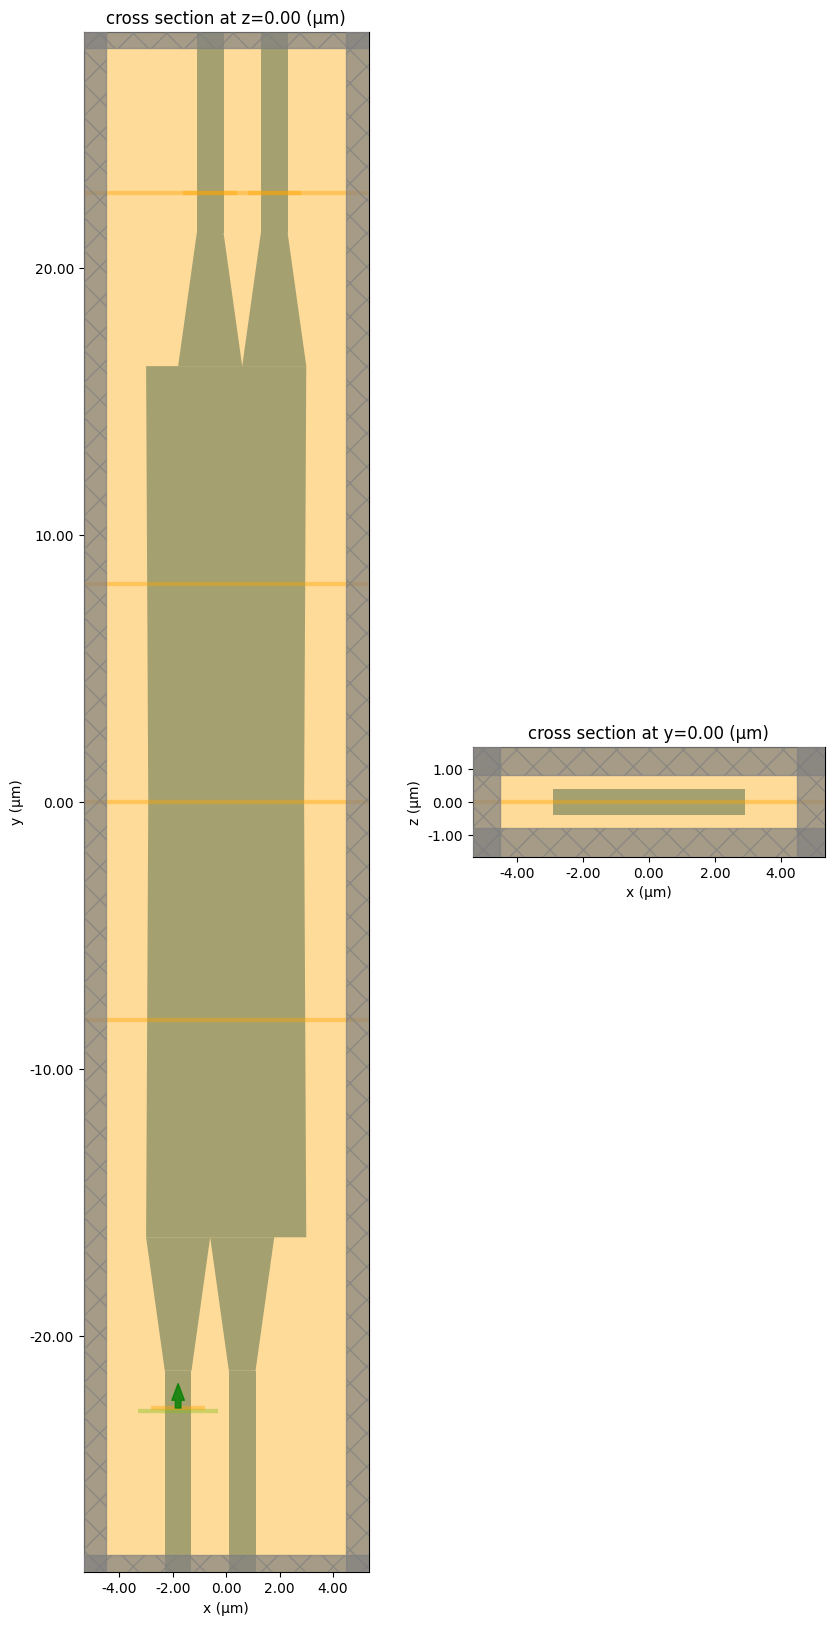

In [9]:

Len_c = 4/3 * neff_TE[0]*(MMI_width * (MMI_width-width_dif2))/1.55
Len_MMI = Len_c * 3/5-opt_len2
print('Len_c', Len_c)
MMI_body = td.Structure(
    geometry = create_ridge_butterfly_ACD(MMI_width,0,-Len_MMI/2,Len_MMI/2,-wg_array_thickness/2,wg_array_thickness/2,0,width_dif2),
    medium = sin,)

Wg_in0 = td.Structure(
    geometry = create_ridge(wg_array_width,input_positions[0],-(Len_MMI/2+taper_length+wvg_length),-(Len_MMI/2+taper_length),-wg_array_thickness/2,wg_array_thickness/2,0),
    medium = sin,
)
Taper_in0 = td.Structure(
    geometry = create_taper(MMI_width*2/5,input_positions[0],-(Len_MMI/2+taper_length),-(Len_MMI/2),-wg_array_thickness/2,wg_array_thickness/2,0,wg_array_width),
    medium = sin,
)

Wg_in1 = td.Structure(
    geometry = create_ridge(wg_array_width,input_positions[1],-(Len_MMI/2+taper_length+wvg_length),-(Len_MMI/2+taper_length),-wg_array_thickness/2,wg_array_thickness/2,0),
    medium = sin,
)
Taper_in1 = td.Structure(
    geometry = create_taper(MMI_width*2/5,input_positions[1],-(Len_MMI/2+taper_length),-(Len_MMI/2),-wg_array_thickness/2,wg_array_thickness/2,0,wg_array_width),
    medium = sin,
)

Wg_out0 = td.Structure(
    geometry = create_ridge(wg_array_width,output_positions[0],(Len_MMI/2+taper_length),(Len_MMI/2+taper_length+wvg_length),-wg_array_thickness/2,wg_array_thickness/2,0),
    medium = sin,
)
Taper_out0 = td.Structure(
    geometry = create_taper(MMI_width*2/5,output_positions[0],(Len_MMI/2+taper_length),(Len_MMI/2),-wg_array_thickness/2,wg_array_thickness/2,0,wg_array_width),
    medium = sin,
)

Wg_out1 = td.Structure(
    geometry = create_ridge(wg_array_width,output_positions[1],(Len_MMI/2+taper_length),(Len_MMI/2+taper_length+wvg_length),-wg_array_thickness/2,wg_array_thickness/2,0),
    medium = sin,
)
Taper_out1 = td.Structure(
    geometry = create_taper(MMI_width*2/5,output_positions[1],(Len_MMI/2+taper_length),(Len_MMI/2),-wg_array_thickness/2,wg_array_thickness/2,0,wg_array_width),
    medium = sin,
)

####

#definimos los monitores y fuentes

mode_spec = td.ModeSpec(
    num_modes=2,
    target_neff=3,
    track_freq="central",
    precision= "double",
    group_index_step=True
)
mode_source = td.ModeSource(
    center = (input_positions[0],-(Len_MMI/2+taper_length+1.5),0),
    size = (3 * wg_array_width,0 , 5*wg_array_thickness),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction = "+",
    mode_spec = mode_spec,
    mode_index=0,
    num_freqs=5,
)
field_monitor1 = td.FieldMonitor(
    center = (0,0,0), size = (td.inf,td.inf,0), freqs=[freq0], name = "field1"
)
field_monitor11 = td.FieldMonitor(
    center = (0,0,wg_array_thickness/2), size = (td.inf,td.inf,0), freqs=[freq0], name = "field11"
)
field_monitor2 = td.FieldMonitor(
    center = (0,0,0), size = (td.inf,0,td.inf), freqs=[freq0], name = "field2"
)
field_monitor3 = td.FieldMonitor(
    center = (0,Len_MMI/4,0), size = (td.inf,0,td.inf), freqs=[freq0], name = "field3"
)
field_monitor4 = td.FieldMonitor(
    center = (0,-Len_MMI/4,0), size = (td.inf,0,td.inf), freqs=[freq0], name = "field4"
)

field_monitor5 = td.FieldMonitor(
    center = (0,(Len_MMI/2+taper_length+1.5),0), size = (td.inf,0,td.inf), freqs=[freq0], name = "field5"
)



flux_monitor0 = td.FluxMonitor(
    center = (input_positions[0],-(Len_MMI/2+taper_length+1.4),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux0",
)


flux_monitor1 = td.FluxMonitor(
    center = (output_positions[0],(Len_MMI/2+taper_length+1.5),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux1",
)

mode_monitor1 = td.ModeMonitor(
    center = (input_positions[0], (Len_MMI/2+taper_length+3/2),0),
    size = (2 * wg_array_width,0 , 5*wg_array_thickness),
    freqs= freqs,
    mode_spec = td.ModeSpec(num_modes=1,target_neff=3),
    name = "mode1",

)

flux_monitor2 = td.FluxMonitor(
    center = (output_positions[1],(Len_MMI/2+taper_length+1.5),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux2",
)

mode_monitor2 = td.ModeMonitor( 
    center = (output_positions[1], (Len_MMI/2+taper_length+3/2),0),
    size = (2 * wg_array_width,0 , 5*wg_array_thickness),
    freqs= freqs,
    mode_spec = td.ModeSpec(num_modes=1,target_neff=3),
    name = "mode2",
)


Lx = 1.5*MMI_width 
Ly= 1.5*(Len_MMI+taper_length) 
Lz = 2*wg_array_thickness
grid_spec = td.GridSpec.auto(min_steps_per_wvl=15,wavelength=1.55)
sim = td.Simulation(
    size = (Lx,Ly,Lz),
    grid_spec = grid_spec,
    run_time = 3e-12,
    boundary_spec= td.BoundarySpec.all_sides(boundary = td.PML()),
    medium=sio2,
    structures=(MMI_body,Wg_in0,Taper_in0,Wg_in1,Taper_in1,Wg_out0,Taper_out0,Wg_out1,Taper_out1),
    sources=[mode_source],
    monitors = [field_monitor1,field_monitor2,field_monitor3,field_monitor4,field_monitor5,flux_monitor0,flux_monitor1,flux_monitor2]#,mode_monitor1,mode_monitor2,flux_monitor00,flux_monitor11,flux_monitor22,mode_monitor00,mode_monitor11,mode_monitor22],
)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1 = sim.plot(z=0, ax=ax1)
ax2 = sim.plot(y=0, ax=ax2)
plt.show()

sim.plot_3d()


In [10]:
job = web.Job(simulation=sim, task_name="MMI_2x2", verbose=True)
estimated_cost = web.estimate_cost(job.task_id)
print(f'The estimated maximum cost is {estimated_cost:.3f} Flex Credits.')

              Created task 'MMI_2x2' with task_id                               
              'fdve-ada4425a-63b4-4961-8cd4-0313b4c818b6' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=293101;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ada4425a-63b4-4961-8cd4-0313b4c818b6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=391425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ada4425a-63b4-4961-8cd4-0313b4c818b6\taskId]8;;\]8;id=293101;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ada4425a-63b4-4961-8cd4-0313b4c818b6\=]8;;\]8;id=378794;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ada4425a-63b4-4961-8cd4-0313b4c818b6\fdve]8;;\]8;id=293101;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ada4425a-63b4-4961-8cd4-0313b4c818b6\-ada4425a-63]8;;\
              ]8;id=293101;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ada4425a-63b4-4961-8cd4-0313b4c818b6\b4-4961-8cd4-0313b4c818b6']8;;\.

              Task folder: ]8;id=633327;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

18:41:01 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:41:02 CEST Maximum FlexCredit cost: 0.112. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

The estimated maximum cost is 0.112 Flex Credits.


In [11]:
sim_data = job.run(path="data/MMI_2x2.hdf5")

18:41:03 CEST status = success

Output()

18:41:07 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

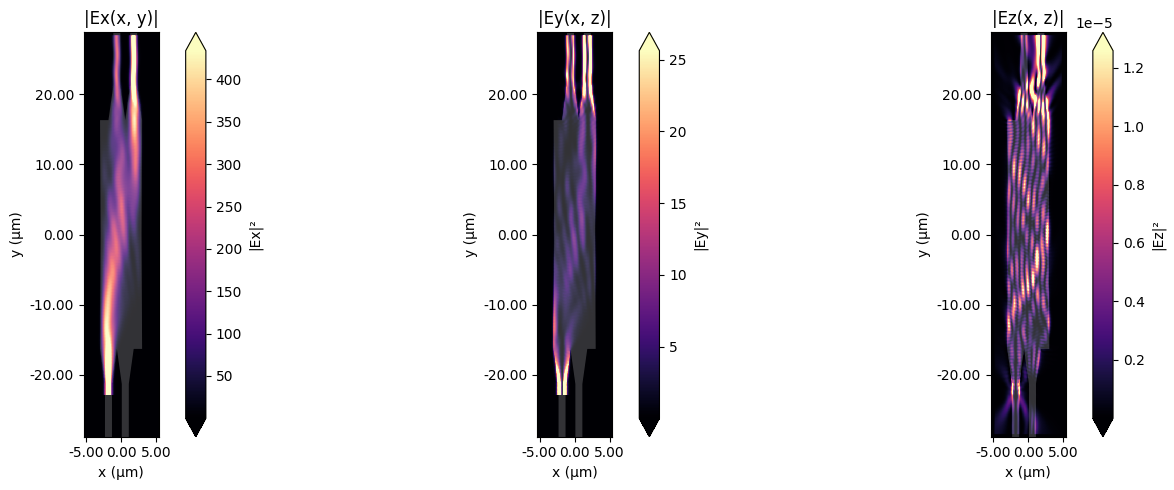

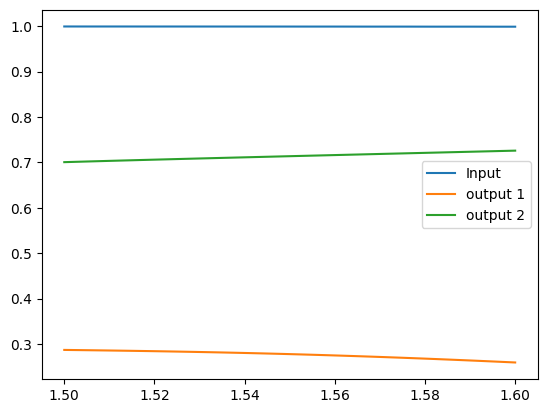

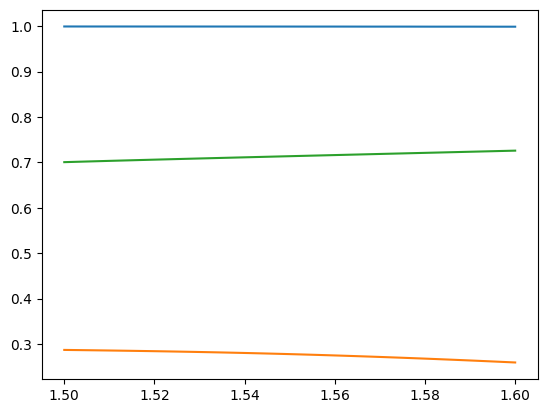

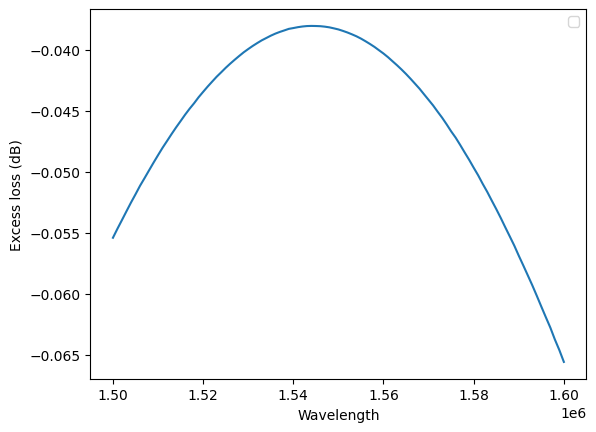

<xarray.FluxDataArray ()> Size: 4B
array(0.28000084, dtype=float32)
Coordinates:
    f        float64 8B 1.934e+14 <xarray.FluxDataArray ()> Size: 4B
array(0.71999913, dtype=float32)
Coordinates:
    f        float64 8B 1.934e+14


In [12]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 5))
sim_data.plot_field("field1", "Ex",val="abs^2", f=freq0, ax=ax1)
sim_data.plot_field("field1", "Ey",val="abs^2", f=freq0, ax=ax2)
sim_data.plot_field("field1", "Ez",val="abs^2", f=freq0, ax=ax3)
ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ey(x, z)|")
ax2.set_aspect("equal")
ax3.set_title("|Ez(x, z)|")
ax3.set_aspect("equal")
plt.show()

#m0 = sim_data["mode00"].amps.sel(mode_index=0, direction="+").abs
#m1 = sim_data["mode1"].amps.sel(mode_index=0, direction="+").abs
#m2 = sim_data["mode2"].amps.sel(mode_index=0, direction="+").abs

#m11 = sim_data["mode11"].amps.sel(mode_index=0, direction="+").abs   
#m22 = sim_data["mode22"].amps.sel(mode_index=0, direction="+").abs
ldas = wvlenth * 1e6  # Convert to nm

T0 = sim_data["flux0"].flux
T1 = sim_data["flux1"].flux
T2 = sim_data["flux2"].flux

plt.plot(wvlenth, T0, label="Input")
plt.plot(wvlenth, T1, label="output 1")
plt.plot(wvlenth, T2, label="output 2")

plt.legend()
plt.show()

plt.plot(wvlenth, T0, label="Input")
plt.plot(wvlenth, T1, label="output 1")
plt.plot(wvlenth, T2, label="output 2")

plt.show()

plt.xlabel("Wavelength ")
plt.ylabel("Transmission to output waveguide")
plt.legend(("Output 0", "Output 1"))

excess_loss = 10*np.log10((T1 + T2))
plt.plot(ldas, excess_loss)
plt.xlabel("Wavelength")
plt.ylabel("Excess loss (dB)")
plt.show()
freq0_pt = len(T1) // 2

print(T1[freq0_pt] / (T1[freq0_pt]+T2[freq0_pt]), T2[freq0_pt]/ (T1[freq0_pt]+T2[freq0_pt]))
